In [2]:
import os
import pyterrier as pt
os.environ["JAVA_HOME"] = "/home/andrew/Java"
os.environ["JVM_PATH"] = '/home/andrew/Java/jre/lib/server/libjvm.so'
if not pt.started():
    pt.init()
import ir_datasets as irds
import pandas as pd
from ir_measures import *
from ir_measures import evaluator

PyTerrier 0.10.0 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
DATASET = "msmarco-passage/trec-dl-2019/judged"
RUN_DIR = '/home/andrew/Documents/Code/Annotation/runs/trec-dl-2019'

In [4]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [5]:
all_runs = []
for run in os.listdir(RUN_DIR):
    result = pt.io.read_results(os.path.join(RUN_DIR, run)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
    result['runname'] = run
    all_runs.append(result)

all_runs = pd.concat(all_runs)

In [6]:
metrics = [nDCG@10]

In [7]:
evaluate = evaluator(metrics, original_qrels)

In [8]:
all_metrics = []

for run, results in all_runs.groupby('runname'):
    if not run.startswith('dl-19'):
        continue
    for obj in evaluate.iter_calc(results):
        all_metrics.append({
            'runname': run,
            'query_id': obj.query_id,
            'metric': obj.measure,
            'value': obj.value
        })

all_metrics = pd.DataFrame(all_metrics)

# Read Pool

In [9]:
POOL_DIR = '/home/andrew/Documents/Code/Annotation/pooling/pool-pilot-study.jsonl'
pool = pd.read_json(POOL_DIR, lines=True)

In [10]:
pool

,text,query,doc_id,query_id,label
0,Chamber Hypertrophy and Enlargment. In hypertr...,causes of left ventricular hypertrophy,2986227,87181,[]
1,The last common cause of right ventricular hyp...,causes of left ventricular hypertrophy,5197133,87181,[]
2,"Over time, this can cause the heart muscle to ...",causes of left ventricular hypertrophy,5469038,87181,[]
3,"Search for new homes, open houses, recently so...",causes of left ventricular hypertrophy,2396481,87181,[]
4,Ventricular hypertrophy. Ventricular hypertrop...,causes of left ventricular hypertrophy,47212,87181,[]
...,...,...,...,...,...
95,Most providers would have you believe that a l...,what does it mean if your tsh is low,1226400,640502,[]
96,1 A low TSH level with a high FT4 level and a ...,what does it mean if your tsh is low,4359297,640502,[]
97,The four TSH assays showed good agreement at l...,what does it mean if your tsh is low,6728990,640502,[]
98,Low TSH and high FT4 levels are usually seen i...,what does it mean if your tsh is low,6730883,640502,[]


## QREL CHECKS

In [11]:
values = original_qrels.relevance.value_counts()

In [12]:
len(original_qrels) # total number of judgements

9260

In [13]:
values[0] / (values[0] + values[1] + values[2] + values[3]) * 100 # percentage of non-relevant judgements

55.70194384449244

In [14]:
(values[0] + values[1]) / (values[0] + values[1] + values[2] + values[3]) * 100 # percentage of non-relevant and partially relevant judgements

72.9913606911447

## Distribution Stats

In [15]:
NUM_ANNOTATORS = 8

In [49]:
filtered_qrels = original_qrels[original_qrels.relevance != 0]

In [55]:
len(filtered_qrels)

4102

In [51]:
queries = {qid : len(filtered_qrels[filtered_qrels['query_id'] == qid]) for qid in filtered_qrels['query_id'].unique()}
annotators = [i for i in range(NUM_ANNOTATORS)]
annotator_load = {a: 0 for a in annotators}
assignments = {a: [] for a in annotators}

In [52]:
for query, num_docs in queries.items():
    # Find the two annotators with the least documents assigned
    sorted_annotators = sorted(annotator_load, key=annotator_load.get)
    annotator_1 = sorted_annotators[0]
    annotator_2 = sorted_annotators[1]

    # Assign the query to these two annotators
    assignments[annotator_1].append(query)
    assignments[annotator_2].append(query)

    # Update the document count for these two annotators
    annotator_load[annotator_1] += num_docs
    annotator_load[annotator_2] += num_docs

In [53]:
annotator_load

{0: 902, 1: 902, 2: 973, 3: 973, 4: 1168, 5: 1168, 6: 1059, 7: 1059}

In [63]:
def swap_queries(assignments, annotator_load, delta=100):
    improved = True
    while improved:
        improved = False
        # Get the annotators with the maximum and minimum load
        max_annotator = max(annotator_load, key=annotator_load.get)
        min_annotator = min(annotator_load, key=annotator_load.get)
        
        max_load = annotator_load[max_annotator]
        min_load = annotator_load[min_annotator]
        
        if max_load - min_load <= delta:
            break
        
        # Try to find a query to swap
        for query in assignments[max_annotator]:
            query_docs = next(d for q, d in queries.items() if q == query)
            
            # Check if swapping this query to the min_annotator helps
            if query not in assignments[min_annotator]:
                # Perform the swap
                assignments[max_annotator].remove(query)
                assignments[min_annotator].append(query)
                
                annotator_load[max_annotator] -= query_docs
                annotator_load[min_annotator] += query_docs
                improved = True
                break
    
    return assignments, annotator_load

In [64]:

# Execute the balancing swap
assignments, annotator_load = swap_queries(assignments, annotator_load, 100)

In [65]:
annotator_load

{0: 1040, 1: 1012, 2: 1017, 3: 1035, 4: 1021, 5: 1021, 6: 1029, 7: 1029}

In [66]:
assignments

{0: ['1129237',
  '87181',
  '87452',
  '130510',
  '146187',
  '156493',
  '148538',
  '183378',
  '489204',
  '855410',
  '915593',
  '1112341'],
 1: ['1121402',
  '1121709',
  '1124210',
  '131843',
  '359349',
  '405717',
  '207786',
  '264014',
  '490595',
  '573724',
  '962179',
  '1063750'],
 2: ['146187',
  '156493',
  '148538',
  '183378',
  '489204',
  '855410',
  '915593',
  '1112341',
  '1121402',
  '1121709',
  '1124210'],
 3: ['131843',
  '359349',
  '405717',
  '207786',
  '264014',
  '490595',
  '573724',
  '962179',
  '1063750',
  '1129237',
  '87181',
  '87452',
  '130510'],
 4: ['168216',
  '451602',
  '1037798',
  '1106007',
  '1113437',
  '1115776',
  '1117099',
  '1133167'],
 5: ['168216',
  '451602',
  '1037798',
  '1106007',
  '1113437',
  '1115776',
  '1117099',
  '1133167'],
 6: ['443396',
  '527433',
  '833860',
  '1103812',
  '1110199',
  '1114646',
  '1114819',
  '19335',
  '104861',
  '182539',
  '47923'],
 7: ['443396',
  '527433',
  '833860',
  '1103812'

In [76]:
queries = {k: v for k, v in sorted(queries.items(), key=lambda item: item[1])}

# Initialize the document count for each annotator
annotator_load = {a: 0 for a in annotators}
assignments = {a: [] for a in annotators}
query_to_annotators = {q: [] for q, _ in queries.items()}

# Step 1: Assign queries to the two annotators with the least load
for query, num_docs in queries.items():
    sorted_annotators = sorted(annotator_load, key=annotator_load.get)
    annotator_1 = sorted_annotators[0]
    annotator_2 = sorted_annotators[1]
    
    assignments[annotator_1].append(query)
    assignments[annotator_2].append(query)
    
    query_to_annotators[query].extend([annotator_1, annotator_2])
    
    annotator_load[annotator_1] += num_docs
    annotator_load[annotator_2] += num_docs

# Step 2: Perform swaps to balance the load while ensuring each query is seen by two annotators
def swap_queries(assignments, annotator_load, query_to_annotators, delta=100):
    improved = True
    
    while improved:
        improved = False
        # Get the annotators with the maximum and minimum load
        max_annotator = max(annotator_load, key=annotator_load.get)
        min_annotator = min(annotator_load, key=annotator_load.get)
        
        max_load = annotator_load[max_annotator]
        min_load = annotator_load[min_annotator]
        
        if max_load - min_load <= delta:
            break
        
        # Try to find a query to swap
        for query in assignments[max_annotator]:
            query_docs = next(d for q, d in queries.items() if q == query)
            
            # Check if the query can be reassigned to the min_annotator
            if (min_annotator not in query_to_annotators[query] and
                len(query_to_annotators[query]) == 2):
                
                # Swap query from max_annotator to min_annotator
                assignments[max_annotator].remove(query)
                assignments[min_annotator].append(query)
                
                query_to_annotators[query].remove(max_annotator)
                query_to_annotators[query].append(min_annotator)
                
                annotator_load[max_annotator] -= query_docs
                annotator_load[min_annotator] += query_docs
                
                improved = True
                break
    
    return assignments, annotator_load, query_to_annotators

# Execute the balancing swap with the constraint
assignments, annotator_load, query_to_annotators = swap_queries(assignments, annotator_load, query_to_annotators, 50)


In [77]:
annotator_load

{0: 1015, 1: 1015, 2: 1028, 3: 1028, 4: 1050, 5: 1050, 6: 1009, 7: 1009}

In [79]:
assignments

{0: ['855410',
  '146187',
  '130510',
  '1110199',
  '490595',
  '573724',
  '87452',
  '489204',
  '156493',
  '451602',
  '1133167',
  '1114646'],
 1: ['855410',
  '146187',
  '130510',
  '1110199',
  '490595',
  '573724',
  '87452',
  '489204',
  '156493',
  '451602',
  '1133167',
  '1114646'],
 2: ['1129237',
  '1121402',
  '359349',
  '527433',
  '87181',
  '148538',
  '1124210',
  '264014',
  '168216'],
 3: ['1129237',
  '1121402',
  '359349',
  '527433',
  '87181',
  '148538',
  '1124210',
  '264014',
  '168216'],
 4: ['1106007', '833860', '915593', '47923', '104861', '183378', '1114819'],
 5: ['1106007', '833860', '915593', '47923', '104861', '183378', '1114819'],
 6: ['19335',
  '962179',
  '405717',
  '182539',
  '131843',
  '1113437',
  '443396',
  '1117099',
  '1112341',
  '1063750',
  '1037798',
  '1115776',
  '1103812',
  '1121709',
  '207786'],
 7: ['19335',
  '962179',
  '405717',
  '182539',
  '131843',
  '1113437',
  '443396',
  '1117099',
  '1112341',
  '1063750',
 

In [78]:
query_to_annotators.values()

dict_values([[0, 1], [6, 7], [6, 7], [6, 7], [0, 1], [6, 7], [6, 7], [6, 7], [0, 1], [2, 3], [6, 7], [6, 7], [0, 1], [2, 3], [0, 1], [6, 7], [0, 1], [2, 3], [4, 5], [6, 7], [0, 1], [2, 3], [4, 5], [6, 7], [0, 1], [2, 3], [4, 5], [6, 7], [0, 1], [2, 3], [4, 5], [6, 7], [0, 1], [2, 3], [4, 5], [6, 7], [0, 1], [2, 3], [4, 5], [6, 7], [0, 1], [2, 3], [4, 5]])

In [16]:
def distribute_instances(annotator_ids, instance_ids, N, K):

    # First round assignment
    first_round = {instance: annotator_ids[i % N] for i, instance in enumerate(instance_ids)}

    # Second round assignment (using d=1, shift by 1)
    second_round = {instance: annotator_ids[(i + 1) % N] for i, instance in enumerate(instance_ids)}

    # Combine both rounds
    assignment = {instance: [first_round[instance], second_round[instance]] for instance in instance_ids}

    return assignment

In [17]:
original_qrels

,query_id,doc_id,relevance,iteration
0,19335,1017759,0,Q0
1,19335,1082489,0,Q0
2,19335,109063,0,Q0
3,19335,1160863,0,Q0
4,19335,1160871,0,Q0
...,...,...,...,...
9255,1133167,8839920,2,Q0
9256,1133167,8839922,2,Q0
9257,1133167,944810,0,Q0
9258,1133167,949411,0,Q0


In [18]:
filtered_qrels = original_qrels[original_qrels.relevance != 0].reset_index(drop=True)

In [19]:
# get number of rows per query 

num_rows = filtered_qrels.groupby('query_id').size().reset_index(name='num_rows')

In [42]:
num_rows

,query_id,num_rows
0,1037798,13
1,104861,141
2,1063750,276
3,1103812,31
4,1106007,60
5,1110199,35
6,1112341,142
7,1113437,77
8,1114646,52
9,1114819,341


In [20]:
instance_ids = filtered_qrels.index.tolist()

In [21]:
annotators_ids = [i for i in range(NUM_ANNOTATORS)]

In [22]:
from collections import defaultdict

In [23]:
assignments = distribute_instances(annotators_ids, instance_ids, NUM_ANNOTATORS, len(instance_ids))
lookup = defaultdict(list)

for instance, annotators in assignments.items():
    for annotator in annotators:
        lookup[annotator].append(instance)

In [24]:
lookup.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [25]:
accum = defaultdict(int)
for annotator, instances in lookup.items():
    print(annotator, len(instances))
    for instance in instances:
        accum[instance] += 1

0 1025
1 1026
2 1026
3 1026
4 1026
5 1026
6 1025
7 1024


In [26]:
450 / 60

7.5

In [27]:
import numpy as np
out = {
    'num_annotators' : [],
    'num_examples' : [],
}

for num_annots in range(3, 9):
    out['num_annotators'].append(num_annots)
    assingments = distribute_instances([i for i in range(num_annots)], instance_ids, num_annots, len(instance_ids))
    accum = defaultdict(int)
    for annotator, instances in assingments.items():
        for instance in instances:
            accum[instance] += 1
    num_docs = np.mean(list(accum.values()))
    out['num_examples'].append(num_docs)

out = pd.DataFrame(out)
    

In [28]:
def compute_hours(num_docs, annotation_time):
    print(annotation_time * 60)
    return num_docs * annotation_time / 60

In [29]:
hours_45 = [compute_hours(num_docs, 45 / 100) for num_docs in out['num_examples'].to_list()]
hours_30 = [compute_hours(num_docs, 30 / 100) for num_docs in out['num_examples'].to_list()]
hours_60 = [compute_hours(num_docs, 60 / 100) for num_docs in out['num_examples'].to_list()]

27.0
27.0
27.0
27.0
27.0
27.0
18.0
18.0
18.0
18.0
18.0
18.0
36.0
36.0
36.0
36.0
36.0
36.0


In [30]:
45 / 100 * 60

27.0

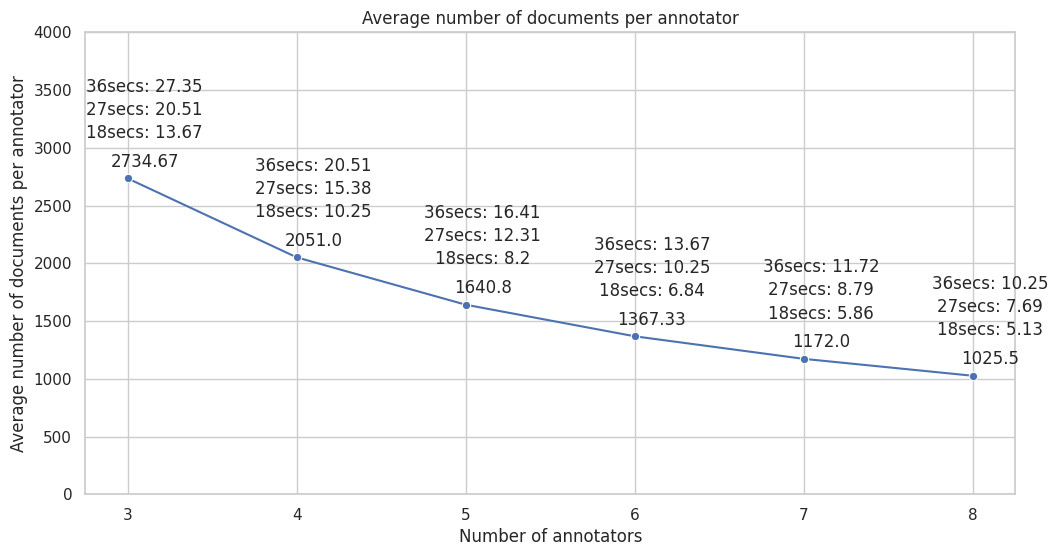

In [31]:
# plot 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='num_annotators', y='num_examples', data=out, marker='o')
# set y range to 0-4000
plt.ylim(0, 4000)
plt.title('Average number of documents per annotator')
plt.xlabel('Number of annotators')
plt.ylabel('Average number of documents per annotator')

# above each point plot a point which is the y value plus 100

for i in range(len(out)):
    plt.text(out['num_annotators'][i] + 0.1, out['num_examples'][i] + 100, round(out['num_examples'][i], 2), ha='center')

for i, hours in enumerate(hours_30):
    plt.text(out['num_annotators'][i] + 0.1, out['num_examples'][i] + 350, f'18secs: {round(hours, 2)}', ha='center')

for i, hours in enumerate(hours_45):
    plt.text(out['num_annotators'][i] + 0.1, out['num_examples'][i] + 550, f'27secs: {round(hours, 2)}', ha='center')

for i, hours in enumerate(hours_60):
    plt.text(out['num_annotators'][i] + 0.1, out['num_examples'][i] + 750, f'36secs: {round(hours, 2)}', ha='center')
    

plt.savefig('average_docs_per_annotator.svg', format='svg')

In [32]:
for instance, count in accum.items():
    if count != 2:
        print(instance, count)

0 1025
1 1026
2 1026
3 1026
4 1026
5 1026
6 1025
7 1024


# Per QID pseudo-Oracle

In [33]:
# find the best performance by each qid, keep the run name and value

best_performances = all_metrics.groupby(['query_id', 'metric']).apply(lambda x: x.loc[x['value'].idxmax()]).reset_index(drop=True)

In [34]:
# using best performance, find the rankings for each query 
all_rankings = []
for row in best_performances.itertuples():
    ranking = all_runs.loc[all_runs['query_id'] == row.query_id]
    ranking = ranking.loc[ranking.runname==row.runname].copy()
    all_rankings.append(ranking)

all_rankings = pd.concat(all_rankings)

In [35]:
best_performances.value.mean()

0.8309784091185828

# Custom nDCG

In [36]:
# from https://github.com/kmbnw/rank_metrics/blob/master/python/ndcg.py

# Copyright 2016 Krysta M Bouzek
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

import numpy as np

"""
Implementation of normalized discounted cumulative gain.

Handy for testing ranking algorithms.

https://en.wikipedia.org/wiki/Discounted_cumulative_gain
"""

def cum_gain(relevance):
    """
    Calculate cumulative gain.
    This ignores the position of a result, but may still be generally useful.

    @param relevance: Graded relevances of the results.
    @type relevance: C{seq} or C{numpy.array}
    """

    if relevance is None or len(relevance) < 1:
        return 0.0

    return np.asarray(relevance).sum()


def dcg(relevance, alternate=True):
    """
    Calculate discounted cumulative gain.

    @param relevance: Graded and ordered relevances of the results.
    @type relevance: C{seq} or C{numpy.array}
    @param alternate: True to use the alternate scoring (intended to
    place more emphasis on relevant results).
    @type alternate: C{bool}
    """

    if relevance is None or len(relevance) < 1:
        return 0.0

    rel = np.asarray(relevance)
    p = len(rel)

    if alternate:
        # from wikipedia: "An alternative formulation of
        # DCG[5] places stronger emphasis on retrieving relevant documents"

        log2i = np.log2(np.asarray(range(1, p + 1)) + 1)
        return ((np.power(2, rel) - 1) / log2i).sum()
    else:
        log2i = np.log2(range(2, p + 1))
        return rel[0] + (rel[1:] / log2i).sum()


def idcg(relevance, alternate=True):
    """
    Calculate pseudo-ideal discounted cumulative gain (maximum possible DCG).

    @param relevance: Graded and ordered relevances of the results.
    @type relevance: C{seq} or C{numpy.array}
    @param alternate: True to use the alternate scoring (intended to
    place more emphasis on relevant results).
    @type alternate: C{bool}
    """

    if relevance is None or len(relevance) < 1:
        return 0.0

    # guard copy before sort
    rel = np.asarray(relevance).copy()
    rel.sort()
    return dcg(rel[::-1], alternate)

def pidcg(upper_bound, alternate=True):
    if upper_bound is None or len(upper_bound) < 1:
        return 0.0

    # guard copy before sort
    rel = np.asarray(upper_bound).copy()
    return dcg(rel, alternate)


def pndcg(relevance, upper_bound, nranks, alternate=True):
    """
    Calculate pseudo normalized discounted cumulative gain.

    @param relevance: Graded and ordered relevances of the results.
    @type relevance: C{seq} or C{numpy.array}
    @param nranks: Number of ranks to use when calculating NDCG.
    Will be used to rightpad with zeros if len(relevance) is less
    than nranks
    @type nranks: C{int}
    @param alternate: True to use the alternate scoring (intended to
    place more emphasis on relevant results).
    @type alternate: C{bool}
    """
    if relevance is None or len(relevance) < 1:
        return 0.0

    if (nranks < 1):
        raise Exception('nranks < 1')

    rel = np.asarray(relevance)
    pad = max(0, nranks - len(rel))

    # pad could be zero in which case this will no-op
    rel = np.pad(rel, (0, pad), 'constant')

    # now slice downto nranks
    rel = rel[0:min(nranks, len(rel))]

    ideal_dcg = idcg(upper_bound, alternate)
    if ideal_dcg == 0:
        return 0.0

    return dcg(rel, alternate) / ideal_dcg

In [37]:
class ndcg_process():
    def __init__(self, qrels, upper_bounds, cutoff=10, merge = False) -> None:
        self.qrels = qrels
        self.upper_bounds = upper_bounds
        self.cutoff = cutoff
        self.calc = self.calc_merge if merge else self.calc_raw

    def calc_merge(self, qrels, results, upper_bound):
        # get top 10 of results
        qrels = qrels.set_index('doc_id').relevance.to_dict()
        results = results.sort_values('score', ascending=False).head(self.cutoff)
        #filter_upper_bound to contain only the documents in results
        upper_bound = upper_bound.loc[upper_bound['doc_id'].isin(results['doc_id'])].sort_values('score', ascending=False)
        # if any docs are missing from upper bound add them to the end with a score of 0
        missing_docs = results.loc[~results['doc_id'].isin(upper_bound['doc_id'])]
        missing_docs['score'] = 0
        upper_bound = pd.concat([upper_bound, missing_docs])

        result_relevance = np.array([qrels.get(doc_id, 0) for doc_id in results['doc_id']])
        upper_bound_relevance = np.array([qrels.get(doc_id, 0) for doc_id in upper_bound['doc_id']])

        return pndcg(result_relevance, upper_bound_relevance, self.cutoff, False)
    
    def calc_raw(self, qrels, results, upper_bound):
        # get top 10 of results
        qrels = qrels.set_index('doc_id').relevance.to_dict()
        results = results.sort_values('score', ascending=False).head(self.cutoff)
        #filter_upper_bound to contain only the documents in results
        upper_bound = upper_bound.sort_values('score', ascending=False).head(self.cutoff)
        result_relevance = np.array([qrels.get(doc_id, 0) for doc_id in results['doc_id']])
        upper_bound_relevance = np.array([qrels.get(doc_id, 0) for doc_id in upper_bound['doc_id']])

        return pndcg(result_relevance, upper_bound_relevance, self.cutoff)
    
    def iter_calc(self, run):
        for qid, results in run.groupby('query_id'):
            qrels = self.qrels.loc[self.qrels['query_id'] == qid]
            upper_bound = self.upper_bounds.loc[self.upper_bounds['query_id'] == qid]
            yield {'query_id' : qid, 'value' : self.calc(qrels, results, upper_bound)}
    
    def calc_aggregate(self, run):
        all_results = []
        for qid, results in run.groupby('query_id'):
            qrels = self.qrels.loc[self.qrels['query_id'] == qid]
            upper_bound = self.upper_bounds.loc[self.upper_bounds['query_id'] == qid]
            all_results.append(self.calc(qrels, results, upper_bound))
        return  {'value' : sum(all_results) / len(all_results)}

In [38]:
ndcg_compute = ndcg_process(original_qrels, all_rankings, cutoff=10, merge=False)

In [39]:
all_metrics = []

for run, results in all_runs.groupby('runname'):
    for obj in ndcg_compute.iter_calc(results):
        all_metrics.append({
            'runname': run,
            'query_id': obj['query_id'],
            'metric': 'pndcg@10',
            'value': obj['value']
        })

all_metrics = pd.DataFrame(all_metrics)

KeyboardInterrupt: 

In [ ]:
all_metrics.to_csv('pndcg.csv')

In [ ]:
all_rankings.name.unique()

array(['ICT-CKNRM_B50', 'TUA1-1', 'p_exp_rm3_bert', 'TUW19-p1-f',
       'ICT-CKNRM_B', 'idst_bert_p2', 'idst_bert_pr2', 'TUW19-p2-f',
       'TUW19-p3-f', 'srchvrs_ps_run2', 'ICT-BERT2', 'idst_bert_pr1',
       'bm25base_prf_p', 'bm25base_rm3_p', 'ms_duet_passage',
       'idst_bert_p1', 'bm25base_ax_p', 'p_bert', 'bm25tuned_prf_p',
       'srchvrs_ps_run3', 'idst_bert_p3'], dtype=object)

In [ ]:
ndcg_compute_merge = ndcg_process(original_qrels, all_rankings, cutoff=10, merge=True)
all_metrics_merge = []

for run, results in all_runs.groupby('runname'):
    for obj in ndcg_compute_merge.iter_calc(results):
        all_metrics_merge.append({
            'runname': run,
            'query_id': obj['query_id'],
            'metric': 'pndcg@10',
            'value': obj['value']
        })

all_metrics_merge = pd.DataFrame(all_metrics_merge)

/tmp/ipykernel_725927/630430655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_docs['score'] = 0
/tmp/ipykernel_725927/630430655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_docs['score'] = 0
/tmp/ipykernel_725927/630430655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [ ]:
all_metrics_merge.to_csv('pndcg_merge.csv')

In [ ]:
all_metrics_merge

,runname,query_id,metric,value
0,colbert_monoelectra-base_msmarco-passage-trec-...,1037798,pndcg@10,0.635245
1,colbert_monoelectra-base_msmarco-passage-trec-...,104861,pndcg@10,1.000000
2,colbert_monoelectra-base_msmarco-passage-trec-...,1063750,pndcg@10,0.946724
3,colbert_monoelectra-base_msmarco-passage-trec-...,1103812,pndcg@10,0.816595
4,colbert_monoelectra-base_msmarco-passage-trec-...,1106007,pndcg@10,0.737082
...,...,...,...,...
8427,tirex_set-encoder-large_msmarco-passage-trec-d...,855410,pndcg@10,1.000000
8428,tirex_set-encoder-large_msmarco-passage-trec-d...,87181,pndcg@10,1.000000
8429,tirex_set-encoder-large_msmarco-passage-trec-d...,87452,pndcg@10,0.962727
8430,tirex_set-encoder-large_msmarco-passage-trec-d...,915593,pndcg@10,0.972534


In [ ]:
for row in all_metrics.groupby('runname').mean().itertuples():
    print(row)

Pandas(Index='colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run', value=0.8490375001363796)
Pandas(Index='colbert_monoelectra-large_msmarco-passage-trec-dl-2019-judged.run', value=0.84501440543523)
Pandas(Index='colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run', value=0.8690123187944401)
Pandas(Index='colbert_rankgpt4_msmarco-passage-trec-dl-2019-judged.run', value=0.8408271257315655)
Pandas(Index='colbert_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run', value=0.8681026171783593)
Pandas(Index='colbert_rankgpt4o_msmarco-passage-trec-dl-2019-judged.run', value=0.8710606033029763)
Pandas(Index='colbert_rankzephyr_msmarco-passage-trec-dl-2019-judged.run', value=0.8099155749791594)
Pandas(Index='colbert_set-encoder-base_msmarco-passage-trec-dl-2019-judged.run', value=0.8753647239218828)
Pandas(Index='colbert_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run', value=0.872315099907381)
Pandas(Index='dl-19-official-input.ICT-BERT2.gz', value=0.15352

/tmp/ipykernel_725927/3863578299.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for row in all_metrics.groupby('runname').mean().itertuples():


In [ ]:
all_metrics.groupby('runname').mean()

/tmp/ipykernel_725927/286102387.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_metrics.groupby('runname').mean()


,value
runname,
colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run,0.849038
colbert_monoelectra-large_msmarco-passage-trec-dl-2019-judged.run,0.845014
colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run,0.869012
colbert_rankgpt4_msmarco-passage-trec-dl-2019-judged.run,0.840827
colbert_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run,0.868103
...,...
tirex_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run,0.804637
tirex_rankgpt4o_msmarco-passage-trec-dl-2019-judged.run,0.798026
tirex_rankzephyr_msmarco-passage-trec-dl-2019-judged.run,0.771088


In [ ]:
for row in all_metrics_merge.groupby('runname').mean().itertuples():
    print(row)

Pandas(Index='colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run', value=0.9109495333707288)
Pandas(Index='colbert_monoelectra-large_msmarco-passage-trec-dl-2019-judged.run', value=0.9152853306919838)
Pandas(Index='colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run', value=0.9323588901695181)
Pandas(Index='colbert_rankgpt4_msmarco-passage-trec-dl-2019-judged.run', value=0.9198131035314614)
Pandas(Index='colbert_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run', value=0.9206434153071665)
Pandas(Index='colbert_rankgpt4o_msmarco-passage-trec-dl-2019-judged.run', value=0.920619632371229)
Pandas(Index='colbert_rankzephyr_msmarco-passage-trec-dl-2019-judged.run', value=0.9088703881362953)
Pandas(Index='colbert_set-encoder-base_msmarco-passage-trec-dl-2019-judged.run', value=0.9241590006358958)
Pandas(Index='colbert_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run', value=0.9292199250899836)
Pandas(Index='dl-19-official-input.ICT-BERT2.gz', value=0.195

/tmp/ipykernel_725927/1478244625.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for row in all_metrics_merge.groupby('runname').mean().itertuples():
